---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import pandas as pd

train_data = pd.read_csv("signnames.csv")


assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

n_train = np.shape(X_train)[0]

# TODO: Number of validation examples
n_validation = np.shape(X_valid)[0]

# TODO: Number of testing examples.
n_test = np.shape(X_test)[0]

# TODO: What's the shape of an traffic sign image?
#image_shape = np.shape(train['features'][0][0])
image_shape = np.shape(train['features'])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.shape(train['labels'])

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Shape of the traffic sign image: ", image_shape)
print("Number of classes =", len(train_data))

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Shape of the traffic sign image:  (34799, 32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

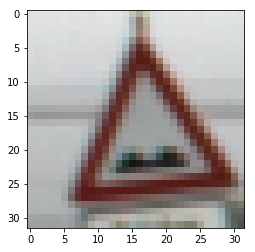

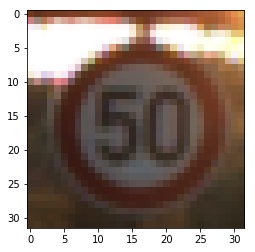

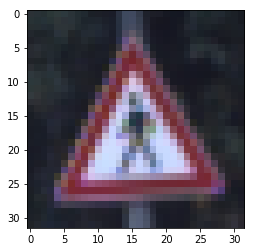

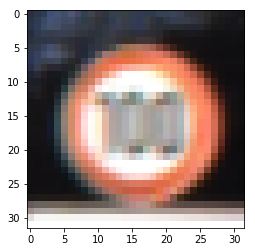

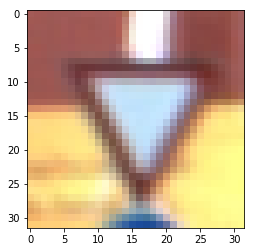

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
for i in range(5):
    rand = np.random.randint(n_train)
    plt.imshow(X_train[rand])
    plt.show()

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

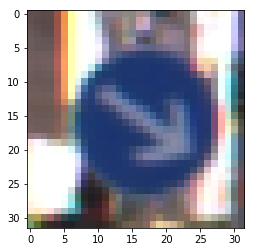

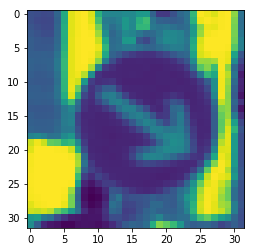

100%|██████████| 32/32 [00:00<00:00, 2099.97it/s]

Applying Gaussian Blur ..


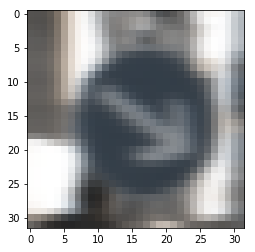

In [4]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# grayscale conversion
from tqdm import tqdm
import cv2

# image normalization by converting to grayscale

def convert_to_gray(data):
    print("Converting to grayscale ..")
    result = []
    for i in tqdm(range(len(data))):
        result.append(cv2.cvtColor(data[i], cv2.COLOR_RGB2GRAY))
    return np.reshape(result,(len(data), 32, 32, 1))

# apply gaussian blur

def gaussian_blur(data):
    print("Applying Gaussian Blur ..")
    result = []
    for i in tqdm(range(len(data))):
        result.append(cv2.GaussianBlur(data[i], (5,5), 0))
        
    return result

rnd = np.random.randint(0, n_train)
img = X_train[rnd]
plt.imshow(img)
plt.show() 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
plt.show()
plt.imshow(gaussian_blur(img))
plt.show() 

# Apply gamma correction

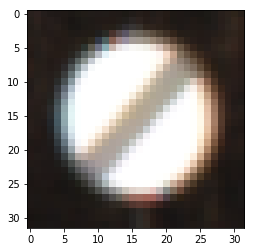

100%|██████████| 32/32 [00:00<00:00, 928.42it/s]

Applying Gamma correction ..


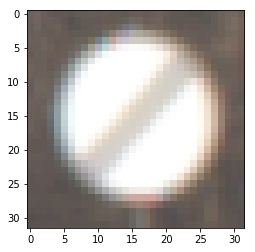

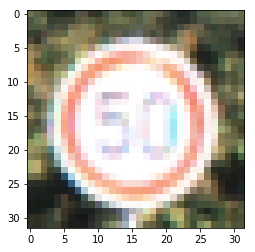

100%|██████████| 32/32 [00:00<00:00, 963.30it/s]

Applying Gamma correction ..


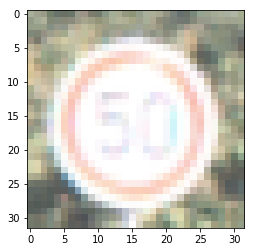

In [5]:
def adjust_gamma(data, gamma=1.0):
    print("Applying Gamma correction ..")
    result = []
    for j in tqdm(range(len(data))):
        # build a lookup table mapping the pixel values [0, 255] to
        # their adjusted gamma values
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
            for i in np.arange(0, 256)]).astype("uint8")

        # apply gamma correction using the lookup table
        result.append(cv2.LUT(data[j], table))
        table = []
    return result

# test out on 2 random images
for i in range(2):
    rnd = np.random.randint(0, len(X_train))
    img = X_train[rnd]
    plt.imshow(img)
    plt.show() 
    gamma_corrected = adjust_gamma(img, 2.2)
    plt.imshow(gamma_corrected)
    plt.show()


In [6]:

# Rotate the image by an angle
#the routine below will work on grayscale images only
def rotation(data, angle):
    print("Rotating ..")
    result = []
    for i in tqdm(range(len(data))):
        img = np.reshape(data[i],(32,32,1))
        rows, cols ,channels = np.shape(img)
        rot_mat = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1.0)
        dst = cv2.warpAffine(img,rot_mat,(cols,rows))
        result.append(dst)
    return np.reshape(result, (len(result),32,32,1))

In [7]:
#image normalization by averaging

def normalize(data):
    # define local variables
    print("Normalizing ..")
    result = []
    second_axis = []
    first_axis = []
    # iterate through entire training set
    for i in tqdm(range(len(data))):
        # iterate through all rows
        for j in range(len(data[0])):
            # iterate through all columns
            for k in range(len(data[0][0])):
                # normalize 
                result.append(((data[i][j][k]/255.0) - 0.5))
            # fill up the row dimension
            second_axis.append(result) 
            #flush data
            result = []
        # fill up the training set dimension
        first_axis.append(second_axis) 
        #flush data
        second_axis = []
        
    return first_axis


## Data Preprocessing

In [8]:
# apply preprocessing to training dataset
# 1. Blur image
# 2. convert to grayscale
# 3. normalize
# 4. gamma correct

def data_preprocessing(X_data):
    X_processed = gaussian_blur(X_data)
    X_processed = convert_to_gray(X_processed)
    X_processed = adjust_gamma(X_processed, 2.2)
    X_processed = normalize(X_processed)
    
    return np.reshape(X_processed,(len(X_processed), 32, 32, 1))




## Dataset Augmentation

In [9]:

def augmented_dataset(X_data, y_data):
    # create empty arrays for augmenting dataset
    X_rotated_left = []
    y_rotated_left = []

    X_rotated_right = []
    y_rotated_right = []
    
    X_rotated_left = rotation(X_data, 10)
    y_rotated_left = y_data
    
    X_rotated_right = rotation(X_data, -10)
    y_rotated_right = y_data
    
    return (np.concatenate((X_data, X_rotated_left, X_rotated_right)),np.concatenate((y_data, y_rotated_left, y_rotated_right))) 



### Model Architecture

In [10]:
### Define your architecture here.


import tensorflow as tf
from tensorflow.contrib.layers import flatten


EPOCHS = 30
BATCH_SIZE = 128

def LeNet(x):    

    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. The output shape should be 28x28x6
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #  Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return [logits, conv1_W, conv2_W, fc1_W, fc2_W, fc3_W]
    

Features and Labels

In [11]:
import pandas as pd

train_data = pd.read_csv("signnames.csv")

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, len(train_data))

### Augment and preprocess the datasets

In [12]:
X_augmented, y_augmented = augmented_dataset(data_preprocessing(X_train), y_train)

X_valid = data_preprocessing(X_valid)
X_test = data_preprocessing(X_test)

 12%|█▏        | 4020/34799 [00:00<00:00, 40198.31it/s]

Applying Gaussian Blur ..


 31%|███       | 10850/34799 [00:00<00:00, 108493.12it/s]

Converting to grayscale ..


  0%|          | 98/34799 [00:00<00:35, 974.76it/s]

Applying Gamma correction ..


  0%|          | 23/34799 [00:00<02:34, 225.71it/s]

Normalizing ..


  7%|▋         | 2602/34799 [00:00<00:01, 26014.01it/s]

Rotating ..


  7%|▋         | 2583/34799 [00:00<00:01, 25823.44it/s]

Rotating ..


  0%|          | 0/4410 [00:00<?, ?it/s]

Applying Gaussian Blur ..
Converting to grayscale ..
Applying Gamma correction ..


  1%|          | 23/4410 [00:00<00:19, 228.73it/s]

Normalizing ..


 36%|███▌      | 4538/12630 [00:00<00:00, 45377.12it/s]

Applying Gaussian Blur ..


  0%|          | 0/12630 [00:00<?, ?it/s]

Converting to grayscale ..
Applying Gamma correction ..


  0%|          | 23/12630 [00:00<00:55, 228.66it/s]

Normalizing ..


100%|██████████| 12630/12630 [00:57<00:00, 220.07it/s]


### Pickle the augmented dataset

In [13]:

with open("train_augmented.p", 'wb') as f:
    pickle.dump((X_augmented, y_augmented),f)

with open("valid_processed.p", 'wb') as f:
    pickle.dump((X_valid, y_valid), f)

with open("test_processed.p", 'wb') as f:
    pickle.dump((X_test, y_test), f)

### Unpickle the augmented dataset files

In [14]:
import pickle
import numpy as np

training_file = "train_augmented.p"
validation_file= "valid_processed.p"
testing_file = "test_processed.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train[0], train[1]
X_valid, y_valid = valid[0], valid[1]
X_test, y_test = test[0], test[1]

### Train, Validate and Test the Model

In [15]:
### Training pipeline

rate = 0.001
reg_constant = 0.0005

[logits, conv1_W, conv2_W, fc1_W, fc2_W, fc3_W] = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

regularizer = tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc2_W) + tf.nn.l2_loss(fc3_W)

loss_operation = tf.reduce_mean(cross_entropy + reg_constant * regularizer)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation)


In [16]:
# Accuracy calculations

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
# Training commands

# Shuffle training set

from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_augmented, y_augmented = shuffle(X_train, y_train)
        
        for offset in tqdm(range(0, num_examples, BATCH_SIZE)):
            end = offset + BATCH_SIZE
            batch_x, batch_y = np.reshape(X_augmented[offset:end], (len(X_augmented[offset:end]), 32, 32 ,1)), y_augmented[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    
    testing_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, keep_prob: 1.0})
    print("testing accuracy = {:.3f}".format(testing_accuracy))
    
    saver.save(sess, './lenet')
    print("Model saved")

Training...



100%|██████████| 816/816 [00:08<00:00, 107.99it/s]


EPOCH 1 ...
Validation Accuracy = 0.821



100%|██████████| 816/816 [00:07<00:00, 112.19it/s]


EPOCH 2 ...
Validation Accuracy = 0.884



100%|██████████| 816/816 [00:07<00:00, 112.13it/s]


EPOCH 3 ...
Validation Accuracy = 0.906



100%|██████████| 816/816 [00:07<00:00, 112.05it/s]


EPOCH 4 ...
Validation Accuracy = 0.928



100%|██████████| 816/816 [00:07<00:00, 112.32it/s]


EPOCH 5 ...
Validation Accuracy = 0.946



100%|██████████| 816/816 [00:07<00:00, 112.10it/s]


EPOCH 6 ...
Validation Accuracy = 0.943



100%|██████████| 816/816 [00:07<00:00, 112.21it/s]


EPOCH 7 ...
Validation Accuracy = 0.944



100%|██████████| 816/816 [00:07<00:00, 113.13it/s]


EPOCH 8 ...
Validation Accuracy = 0.947



100%|██████████| 816/816 [00:07<00:00, 112.26it/s]


EPOCH 9 ...
Validation Accuracy = 0.948



100%|██████████| 816/816 [00:07<00:00, 112.28it/s]


EPOCH 10 ...
Validation Accuracy = 0.959



100%|██████████| 816/816 [00:07<00:00, 112.30it/s]


EPOCH 11 ...
Validation Accuracy = 0.954



100%|██████████| 816/816 [00:07<00:00, 112.74it/s]


EPOCH 12 ...
Validation Accuracy = 0.960



100%|██████████| 816/816 [00:07<00:00, 112.36it/s]


EPOCH 13 ...
Validation Accuracy = 0.963



100%|██████████| 816/816 [00:07<00:00, 112.16it/s]


EPOCH 14 ...
Validation Accuracy = 0.956



100%|██████████| 816/816 [00:07<00:00, 112.23it/s]


EPOCH 15 ...
Validation Accuracy = 0.961



100%|██████████| 816/816 [00:07<00:00, 112.11it/s]


EPOCH 16 ...
Validation Accuracy = 0.959



100%|██████████| 816/816 [00:07<00:00, 112.36it/s]


EPOCH 17 ...
Validation Accuracy = 0.952



100%|██████████| 816/816 [00:07<00:00, 112.30it/s]


EPOCH 18 ...
Validation Accuracy = 0.959



100%|██████████| 816/816 [00:07<00:00, 112.25it/s]


EPOCH 19 ...
Validation Accuracy = 0.958



100%|██████████| 816/816 [00:07<00:00, 111.82it/s]


EPOCH 20 ...
Validation Accuracy = 0.957



100%|██████████| 816/816 [00:07<00:00, 112.59it/s]


EPOCH 21 ...
Validation Accuracy = 0.954



100%|██████████| 816/816 [00:07<00:00, 112.18it/s]


EPOCH 22 ...
Validation Accuracy = 0.959



100%|██████████| 816/816 [00:07<00:00, 112.17it/s]


EPOCH 23 ...
Validation Accuracy = 0.959



100%|██████████| 816/816 [00:07<00:00, 112.13it/s]


EPOCH 24 ...
Validation Accuracy = 0.957



100%|██████████| 816/816 [00:07<00:00, 112.30it/s]


EPOCH 25 ...
Validation Accuracy = 0.963



100%|██████████| 816/816 [00:07<00:00, 112.21it/s]


EPOCH 26 ...
Validation Accuracy = 0.952



100%|██████████| 816/816 [00:07<00:00, 111.96it/s]


EPOCH 27 ...
Validation Accuracy = 0.965



100%|██████████| 816/816 [00:07<00:00, 112.06it/s]


EPOCH 28 ...
Validation Accuracy = 0.960



100%|██████████| 816/816 [00:07<00:00, 112.34it/s]


EPOCH 29 ...
Validation Accuracy = 0.964



100%|██████████| 816/816 [00:07<00:00, 112.05it/s]


EPOCH 30 ...
Validation Accuracy = 0.962

testing accuracy = 0.940
Model saved


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

---

## Step 3: Test a Model on New Images

Test images were downloaded from the internet. They were of different sizes and were reshaped to 32X32X3 to be processed by the algorithm which reatins the central part of the image.
The images are different from the training set in that the background is natural sky, some images have watermarks and have a pole that holds the sign up. Also it appears that a few images were taken with the sign slightly at a higher angle than the camera. These qualities might make them slighyly more challenging to classify.

Image 1 and Image 2 have a watermark on them and a post holding the sign up. The photograph isnt taken with the camera placed right in front of the image, hence the image is warped slightly. Also speed limit signs of 30 mph, 50 mph and 60 mph are very similar and the categories may be mised up. Image 3 and Image 4 also have a post holding the sign up. Image 3 is slightly cropped after reshaping to 32X32X3 because of the original shape. Image 5 has a distraction in the background. But for all the images the sign does occupy most of the image space and should eb classified clearly

### Load and Output the Images

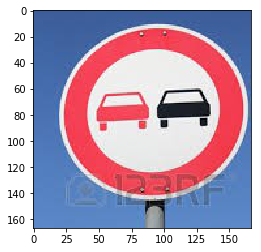

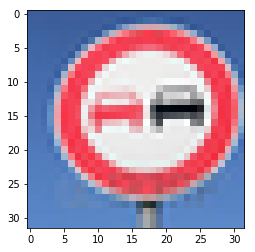

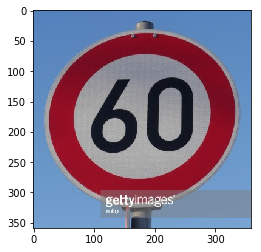

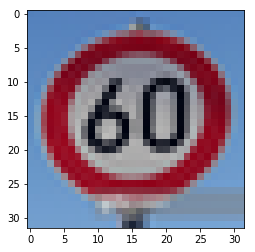

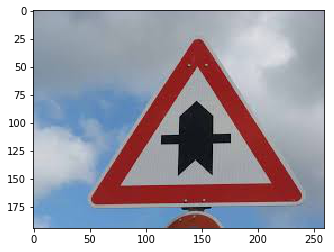

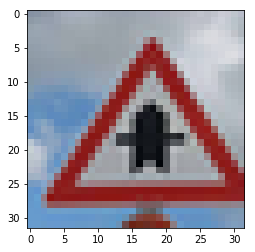

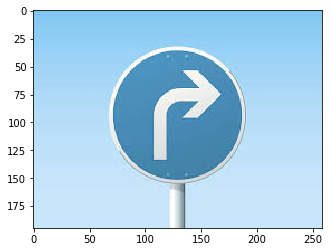

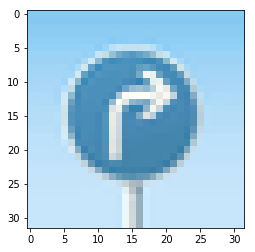

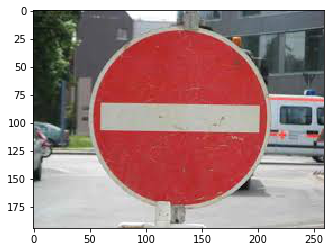

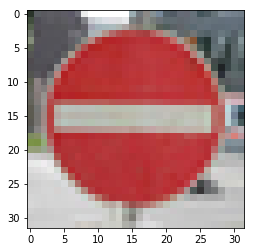

In [18]:
### Load the images and plot them here.
import os
import matplotlib.image as mpimg
from PIL import Image
from resizeimage import resizeimage
import matplotlib.pyplot as plt
import numpy as np

test_set = []
test_images_path = "test-set/"
output_images_path = "output-set/"
test_images = os.listdir(test_images_path)

i=0
image = []
for image in test_images:
    with open(test_images_path+image, 'r+b') as f:
        with Image.open(f) as test_image:
            plt.imshow(test_image)
            plt.show()
            cover = resizeimage.resize_cover(test_image, (32, 32, 3))
            plt.imshow(cover)
            plt.show()
            cover.save(output_images_path+image, test_image.format)
            test_set.append(np.copy(cover))
    i+=1

## Preprocess new images

In [19]:
test_set = data_preprocessing(test_set)


100%|██████████| 5/5 [00:00<00:00, 226.55it/s]

Applying Gaussian Blur ..
Converting to grayscale ..
Applying Gamma correction ..
Normalizing ..


### Predict the Sign Type for Each Image

The top 5 predictions for each sign are summarized below

In [61]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
import tensorflow as tf
with tf.Session() as sess:
    saver.restore(sess,'./lenet')
    predicted_logits=sess.run(logits,feed_dict={x:test_set, keep_prob: 1})
    predicted_prob=sess.run(tf.nn.softmax(predicted_logits))
    predicted_labels = np.argmax(predicted_logits, axis=1)
    y_valid = [ 9, 3, 11, 33, 17]
    test_images_accuracy = evaluate(test_set, y_valid)
    print("Test Images Accuracy = {:.3f}".format(test_images_accuracy))
    
    top_5 = sess.run(tf.nn.top_k(tf.constant(predicted_prob), k=5))

    print(top_5)

Test Images Accuracy = 0.800
TopKV2(values=array([[  8.15890849e-01,   1.55295059e-01,   2.34036800e-02,
          1.47682882e-03,   8.04828422e-04],
       [  9.63033497e-01,   2.10593324e-02,   1.42696928e-02,
          1.50926190e-03,   5.49342985e-05],
       [  9.99985695e-01,   7.53442418e-06,   3.55721841e-06,
          1.91754839e-06,   8.84569488e-07],
       [  9.99321699e-01,   1.82615608e-04,   1.51258297e-04,
          1.19827477e-04,   5.50227633e-05],
       [  9.99975681e-01,   9.78083972e-06,   3.89704792e-06,
          3.10495352e-06,   3.02649141e-06]], dtype=float32), indices=array([[ 9, 17, 41, 16,  8],
       [ 2,  1,  3,  5, 31],
       [11, 30, 40, 21, 33],
       [33,  1, 35, 11, 40],
       [17,  9, 34, 41, 40]], dtype=int32))


#### Results Inpterpretation

The top 5 guesses for each image is summarized above.
For Eg for image 1

[ 9.75662231e-01,   1.35783795e-02,   5.24106296e-03, 1.70061318e-03,   1.01556245e-03] and the probablities of finding 
[ 9, 17, 16,  8, 10] labels
97.5% probability that the first corresponds to label 9, 1.35% probability of it being label 17 and so on. Image has been incorrectly classified as a 50 mph speed limit. The correct sign is 60 mph speed limit


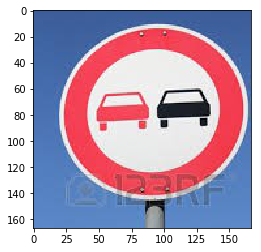

Prediction: 9    No passing
Name: SignName, dtype: object


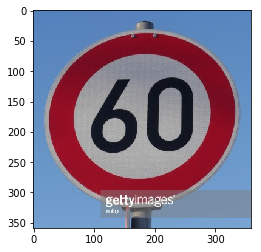

Prediction: 2    Speed limit (50km/h)
Name: SignName, dtype: object


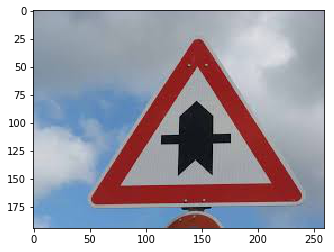

Prediction: 11    Right-of-way at the next intersection
Name: SignName, dtype: object


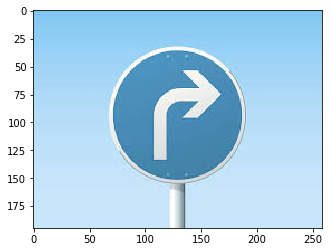

Prediction: 33    Turn right ahead
Name: SignName, dtype: object


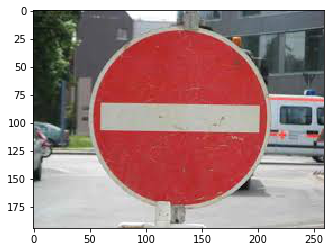

Prediction: 17    No entry
Name: SignName, dtype: object


In [21]:
train_data = pd.read_csv("signnames.csv")    

test_images_path = "test-set/"
test_images = os.listdir(test_images_path)

i=0
image = []
for image in test_images:
    with open(test_images_path+image, 'r+b') as f:
        with Image.open(f) as test_image:
            plt.imshow(test_image)
            plt.show()
            print('Prediction:', train_data[train_data['ClassId']==predicted_labels[i]]['SignName'])
    i+=1



### Results Interpretation

The above images show the correct prediction of images 1, 3, 4 and 5. Image 2 is wrongly classified as a 50 mph sign. The class labels 20 mph, 30 mph, 50 mph, 60 mph, 70 mph and 80 mph are very similar.